## 10 - Clustering
### Finding latent groups in data

We continue our journey in multivariate data analysis, but this time we consider the issue from another angle. While EFA and CFA were concerned with taking a set of variables and finding a new set of *variables* - the factors - that underpinned the originals, we will consider a complimentary approach that aims to find groups of individual *observations* that exist in the data.

These clustering approaches are typically not linear models, but are more algorithmic in nature. This means that they are often more descriptive in nature rather than inferential, but are nonetheless a useful tool to explore data with. Similarly to EFA, the clustering approaches we will use require us to select the number of clusters or groups of observations in order to obtain them, but with slight differences.

Unlike EFA and CFA, there are *many* types of clustering algorithms. We will focus on just one here, which is the **hierarchical clustering** approach (absolutely no relation to hierarchical linear models!). While this is not a linear model, it has a clear and intuitive appeal because it builds a 'tree' of all the observations in the dataset, and arranges them in terms of how similar they are to one another. This is the *dendrogram*. While we don't need to know the details of this similarity, suffice it to say that the approach figures this out by working out the straight-line distance between observations, and those which are closer together are arranged together.

Let's see how we do this. To carry it out we'll use a some new packages, namely the`scipy` submodule dedicated to hierarchical clustering and visualising the trees. We'll also rely on a metric that establishes cluster quality from a package called `sklearn` called the *silhouette coefficient*. Lets import these things along with everything else we need - notice here we also import `matplotlib.pyplot as plt`, which allows us much more flexibility in our graphs. 

In [1]:
# Import all needed packages
import pandas as pd # dataframes
import seaborn as sns # plots
import numpy as np # numpy for some functions
import scipy.cluster.hierarchy as shc # for clustering
from sklearn.metrics import silhouette_score # The silhouette coefficient function
import matplotlib.pyplot as plt # more flexible plotting

sns.set_style('whitegrid')

### Building a tree - the workings of hierarchical clustering
To demonstrate how hierarchical clustering works, we'll first read in a dataset that can illustrate it. This `xclara` is of simulated, idealised data that has a few obvious clusters present on just two variables. Clustering can work on datasets with many columns, its just easy to plot one with two columns!

First, we'll read it in and make a scatterplot:

,rownames,V1,V2
0,1,2.072345,-3.241693
1,2,17.936710,15.784810
2,3,1.083576,7.319176


<Axes: xlabel='V1', ylabel='V2'>

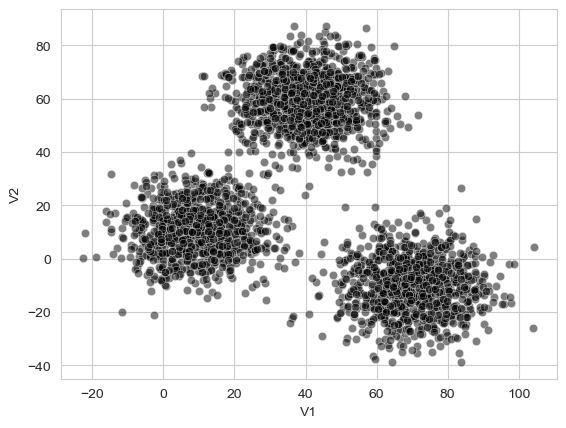

In [2]:
# Read in xclara dataset and plot
xclara = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/cluster/xclara.csv')
display(xclara.head(3))

# Scatter
sns.scatterplot(data=xclara, x='V1', y='V2', color='black', alpha=.5)

Unlike most of the datasets we've seen so far, this one doesn't really *mean* anything, it just serves to nicely illustrate what clusters look like if they exist! They are pretty obvious here. Our goal is to use our hierarchical clustering approach to see if each data point can be assigned to a specific "group". 

#### Building a tree - the linkage array
The build our hierarchical tree, we compute something called the linkage array. The technical details of this are unimportant, but the basic idea is that it describes how the algorithm moves through the dataset, figuring out how similar each datapoint is to all the others, and then joining the most similar datapoints into a cluster of their own, and repeating the process until *all* the datapoints are in a single cluster. Indeed, how the algorithm decides to group datapoints is itself something we need to decide on. We'll stick to something called 'Wards method' here, which for our purposes simply means a cluster will be formed when the variance of a set of points that *might* be a cluster is as low as possible. Despite the technical aside, actually computing this is very simple, like so:

In [3]:
# Compute the linkage array
tree = shc.linkage(xclara[['V1', 'V2']], method='ward')

We simply pass the data we want to cluster into it, and set the method to 'ward'.

### Building a tree - the dendrogram
After obtaining the linkage array, we can now visualise it. This will reveal where the technique gets its name.

To visualise the actual clustering tree, we use the the `.dendrogram` plotting function. With large datasets like this one, it can be hard to see, so we will ask `matplotlib` to make the figure larger:

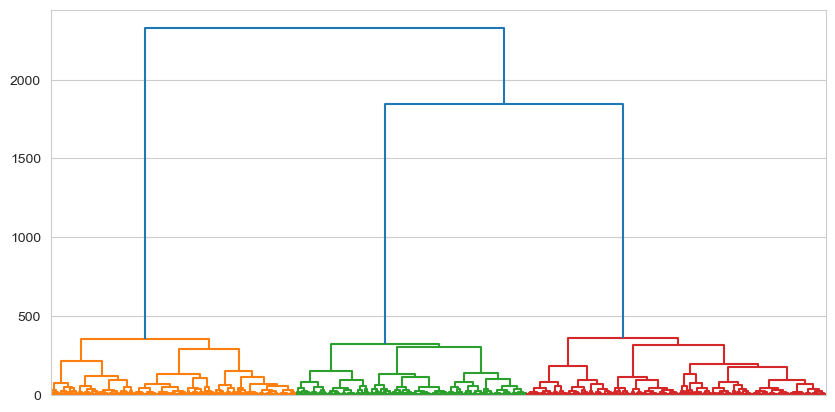

In [4]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # Makes a larger plot

# Plot the tree
dendrogram = shc.dendrogram(tree, ax=ax, no_labels=True) # Plots the dendrogram

What are we looking at here? The very bottom of the dendrogram shows the individual datapoints. From the perspective of the algorithm, these individual datapoints are actually just groups with a single observation in them. As you move up the tree, those individuals cluster together with their most similar individuals, forming new groups. This process continues up the three until there is a single cluster that encompasses *everyone*. To press the tree analogy, this is the root, and the invididuals at the bottom are the leaves.

What is interesting here is the appearance of a clear set of 'branches' in the centre of the plot, with all the subsequent observations grouping together into them quite neatly (as you'd expect for a dataset designed to illustrate clustering!). The dendrogram offers a clear visualisation of the structure of similarity amongst datapoints. 

### Cutting a tree - getting clusters from trees
While a dendrogram is a very nice visual description of the clustering process any patterns in that process, we still do not have what we came for - groups! The next step is to decide how many groups we want to extract from the tree, and we can do that by literally cutting the tree across the Y-axis. All values that fall below the Y-axis cut fall into the cluster that they are connected to directly above the Y-axis cut. 

For example, let's visually cut the dendrogram at a Y-axis position of 2000. We can add a line to demonstrate, and also tell the `dendrogram` function to colour things in separately for observations below that point.

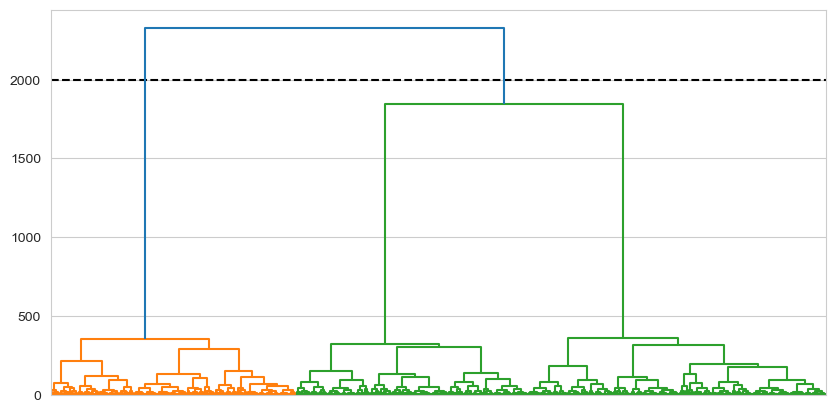

In [5]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # Makes a larger plot
ax.axhline(2000, color='black', linestyle='dashed') # Adds a visual cut

# Plot the tree, colouring below 2000
dendrogram = shc.dendrogram(tree, ax=ax, no_labels=True, color_threshold=2000) # Plots the dendrogram

This clearly gives us *two* clusters, because those observations falling below that point are subsumed by two 'branches'. Equivalently, if we were to cut at 2,600:

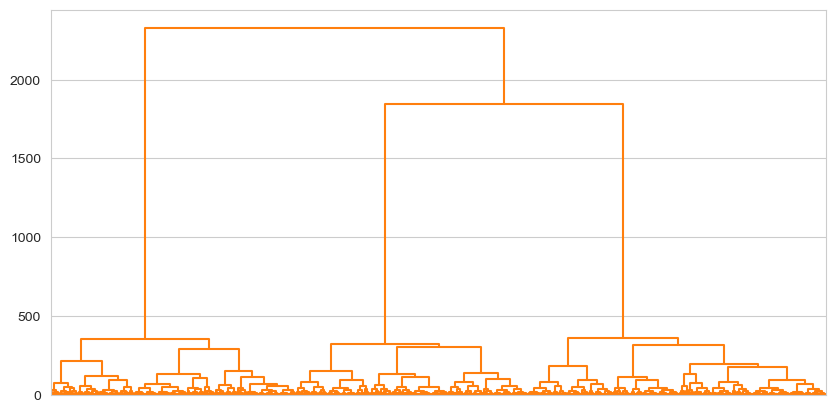

In [6]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # Makes a larger plot
ax.axhline(2600, color='black', linestyle='dashed') # Adds a visual cut

# Plot the tree, colouring below 2000
dendrogram = shc.dendrogram(tree, ax=ax, no_labels=True, color_threshold=2600) # Plots the dendrogram

Everything is a uniform colour, because everything falls below that point. Similarly then, if we cut at 300:

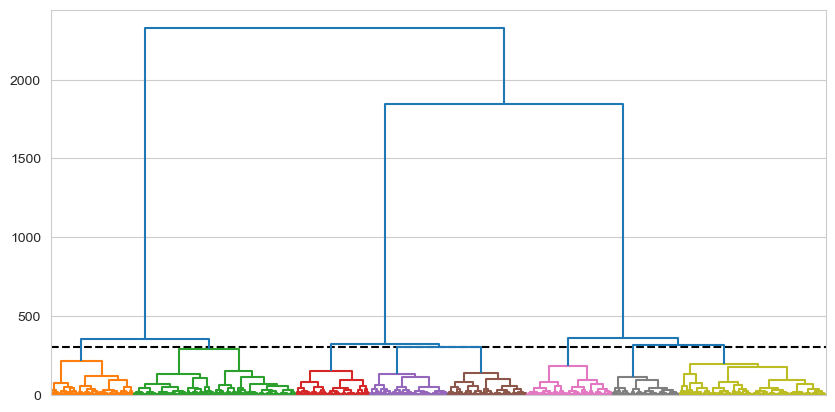

In [7]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # Makes a larger plot
ax.axhline(300, color='black', linestyle='dashed') # Adds a visual cut

# Plot the tree, colouring below 2000
dendrogram = shc.dendrogram(tree, ax=ax, no_labels=True, color_threshold=300) # Plots the dendrogram

A multitude of clusters are obtained as the cut is above many branches leading to separate clusters.

With the visual intuition behind our chops, lets now actually make a cut and obtain the clusters. We do this using the `cut_tree` function, and tell it the height at which we cut the three. We'll use a height of 1500 as this looks like it can represent three clusters well. We cut the tree which will give each observation a group label (e.g. group 0, 1, 2) and add it back to the original dataframe, `xclara`, alongside the data:

In [8]:
# Cutting the tree
labels = shc.cut_tree(tree, height=1500)

# add to dataframe with the name 'cluster'
xclara['cluster'] = labels

# Show
xclara.head()

,rownames,V1,V2,cluster
0,1,2.072345,-3.241693,0
1,2,17.936710,15.784810,0
2,3,1.083576,7.319176,0
3,4,11.120670,14.406780,0
4,5,23.711550,2.557729,0


And now we can visualise our results, colouring each point by its assigned group:

<Axes: xlabel='V1', ylabel='V2'>

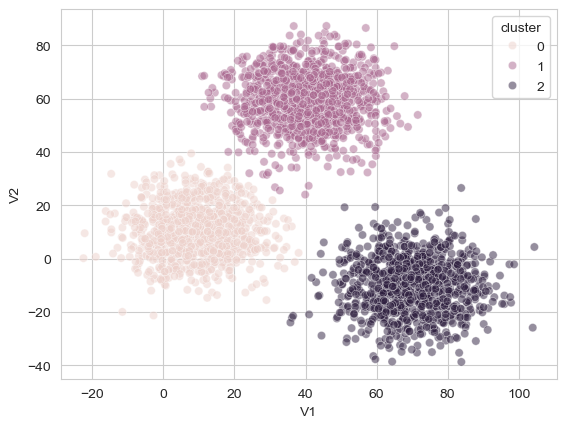

In [9]:
# Visualise
sns.scatterplot(data=xclara, x='V1', y='V2', hue='cluster', alpha=.5)

As can be seen, the algorithm did a fantastic job of tying together those separate groups of points! One of the nice benefits of this tree-like approach to clustering is that it allows the researcher to make a visual judgement and reason about the likely number of clusters in the data. Note that here we could easily visualise these clusters because the original dataset was two dimensional, and this will not always be the case!

### Evaluating a tree - determining the quality of a cluster
With EFA, we could evaluate our clustering by looking at the cumulative variance explained - how much variance the factors explained in the original dataset. How can we evaluate our clustering? We use a statistic called the **silhouette coefficient**. The general intuition of this statistic, which varies from -1 to 1, is that it compares the similarity of data points within a cluster to the similarity of the data points in other clusters. If this value, is on average, high (above 0.70 or so), then the number of clusters is appropriate. If it is between 0.5 and 0.70 then it is reasoable, and above 0.25 to 0.5 a weak clustering. Below those values it indicates the clustering is poor, or indeed, if it is less than 0 it suggests observations in clusters are more similar to those in *other* clusters. Its calculation is simple - we pass the original data and the cluster labels obtained from our tree cutting to the `silhouette_score` function:

In [10]:
# Calculate silhouette
silhouette_score(xclara[['V1', 'V2']], xclara['cluster'])

0.6941949594065251

This suggests a reasonably strong clustering solution with three clusters.

## An applied example - clustering cultures based on personality traits
A real-world example will cement these principles. 

Grice & Iwasaki (2007) collected data from three different cultural groups in the United States - European Americans, ostensibly Caucasian individuals who had lived in the US all their life, Asian Americans, who were Asian individuals who had lived in the US since at least early childhood, and Asian Internationals, Asian individuals who had moved to the US after their sixth birthday. Each respondent completed a Big 5 personality questionnaire, obtaining a score on each of the 5 traits. While we know ahead of time there are groups in this data - *which we often dont* - we can still use this dataset to see if clusters do indeed emerge solely from the personality scores. 

We read in the data from this link: https://vincentarelbundock.github.io/Rdatasets/csv/heplots/Iwasaki_Big_Five.csv


In [11]:
# Read in data
five_culture = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/heplots/Iwasaki_Big_Five.csv')
five_culture.head()

,rownames,ID,Group,N,E,O,A,C
0,1,1,Asian_Intl,87,117,130,124,127
1,2,2,Asian_Intl,101,134,123,115,124
2,3,3,Asian_Intl,63,135,111,71,134
3,4,4,Asian_Intl,104,118,108,107,111
4,5,5,Asian_Intl,70,114,110,119,120


This is self explanatory. We will ignore (for now) the `Group` variable, and build a hierarchical tree on the personality score columns (OCEAN). It is sometimes useful to standardise your data before clustering, especially if the variables are measured on different scales, which we will do as an extra step below. We will then build a tree and visualise it.

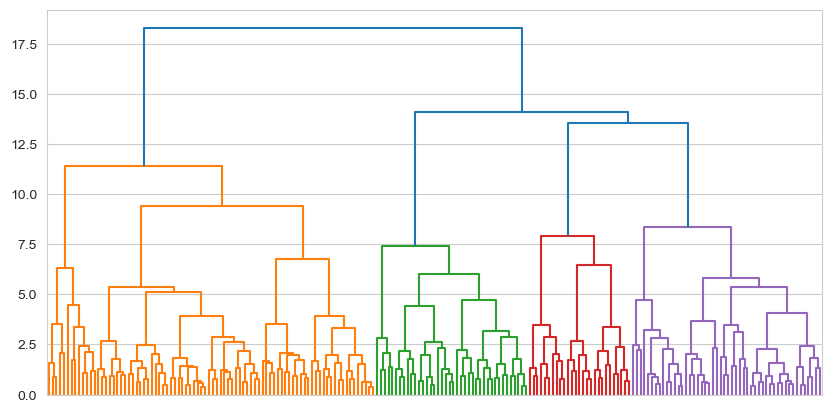

In [12]:
# Standardise columns
from scipy.stats import zscore # Grab the zscore function

# Standardise
five_culture[['N', 'E', 'O', 'A', 'C']] = five_culture[['N', 'E', 'O', 'A', 'C']].apply(zscore) # Overwrite columns with a zscored version

# Build a tree
tree = shc.linkage(five_culture[['N', 'E', 'O', 'A', 'C']], method='ward')

# Visualise
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
big_five_tree = shc.dendrogram(tree, no_labels=True, ax=ax)

This sort of pattern is much more representative of clustering with real data. We can see evidence of around four clusters here, imagining a cut at around 12.5, though we could even consider a cut at around 10, which would yield us five. We could even cut this into three clusters at a Y-axis value of 13. This is up to us of course - there are no 'right' answers. We can evaluate a set of cuts with the silhouette coefficient, which we do next.

In [13]:
# Make a set of cuts
clusters_3 = shc.cut_tree(tree, height=14)
clusters_4 = shc.cut_tree(tree, height=12.5)
clusters_5 = shc.cut_tree(tree, height=10)

# And evaluate these with the silhouette score
# the 'flatten' method makes the labels 1 dimensional which silhouette_score wants
silhouette_3 = silhouette_score(five_culture[['N', 'E', 'O', 'A', 'C']], clusters_3.flatten()) 
silhouette_4 = silhouette_score(five_culture[['N', 'E', 'O', 'A', 'C']], clusters_4.flatten())
silhouette_5 = silhouette_score(five_culture[['N', 'E', 'O', 'A', 'C']], clusters_5.flatten())

# Display
display('Three clusters:', silhouette_3, 'Four clusters:', silhouette_4, 'Five clusters:', silhouette_5)

'Three clusters:'

0.13628548582932207

'Four clusters:'

0.153040712987108

'Five clusters:'

0.15455977226524698

What have we learned here? It seems like that however many clusters we pick, they are actually quite weak. This indicates to us that the clusters are not particularly strong. However, it does also suggest that a four or five cluster solution is marginally better. Which to pick? You could take either, but I will select four since it is simpler. We will continute with that, adding those cluster labels back to the dataset. 

We could then visualise the personality profiles of those four groups, after melting our data (refer to chapter one for a refresher!).

In [14]:
# Add the 5 cluster labels back
five_culture['clusters'] = clusters_4

# Melt the data for plotting
plot_this = five_culture.melt(id_vars=['ID', 'Group', 'clusters'],
                              value_vars=['N', 'E', 'O', 'A', 'C'],
                              var_name='trait', value_name='score')

display(plot_this.head()) # Show the melted data

,ID,Group,clusters,trait,score
0,1,Asian_Intl,0,N,-0.420411
1,2,Asian_Intl,0,N,0.240434
2,3,Asian_Intl,1,N,-1.553288
3,4,Asian_Intl,1,N,0.382044
4,5,Asian_Intl,0,N,-1.222866


And visualise:

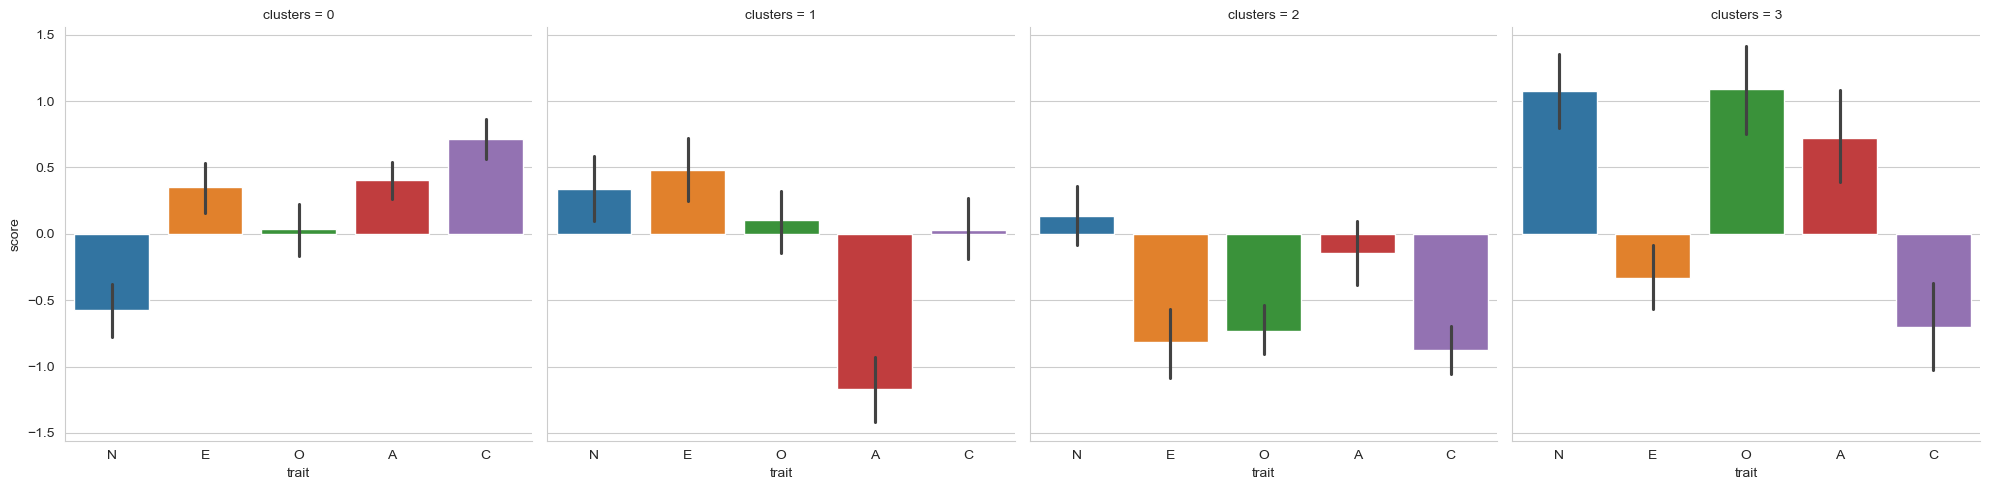

In [15]:
# visualise
sns.catplot(data=plot_this,
            x='trait', y='score', 
            hue='trait', col='clusters',
            col_wrap=2, kind='bar')

What we've learned here is that:
- People in cluster 0 have lower than average Neuroticism, very average Openness, and slightly higher than average Extraversion, Agreeableness, and Conscientiousness.
- People in cluster 1 have much lower than average Agreeableness (not nice people!), very average Conscientiousness and Openness, with slightly higher scores on Extraversion and Neuroticism.
- People in cluster 2 have rather lower than average Extraversion, Openness, and Conscientiousness, and average scores on Neuroticism and Agreeableness.
- People in cluster 4 have high scores on Neuroticism, Openness, and Agreeableness, but lower scores on Extraversion and Conscientiousness.

Coarsely speaking we might imagine: 
- Those in cluster 0 as relaxed, outgoing, friendly, and hard working, but not particularly creative.
- Those in cluster 1 as unfriendly, slightly anxious but outgoing, and not particularly creative or hardworking.
- Those in cluster 2 as introverted, close minded, and disorganised.
- Those in cluster 3 as anxious, disorganised, and a little introverted, but very creative and very friendly.

But remember - this clustering solution was quite weak! As a final interesting test we might compare the cluster labels with the actual ethnic groups to see if there is any concordance, using `pd.crosstab`.

In [16]:
# Crosstabs
pd.crosstab(five_culture['Group'], five_culture['clusters'])

clusters,0,1,2,3
Group,,,,
Asian_Amer,25,15,23,9
Asian_Intl,39,18,15,3
Eur,22,7,12,15


Not really! 

Clustering is again a powerful tool but must be used with circumspection, requiring careful consideration of the data, questions, and problem at hand. Its possible to also combined clustering and techniques like factor analysis, where a researcher might reduce a large number of column-variables down to their latent factors, and then perform clustering on the factor scores to see how people group together on those latent variables. 